# Utility functions and imports

In [ ]:
import os
import io
import PIL.Image, PIL.ImageDraw
import base64
import zipfile
import json
import requests
import numpy as np
import matplotlib.pylab as pl
import glob
import tensorflow as tf
from tensorflow.keras.layers import Conv2D
from IPython.display import Image, HTML, clear_output
import tqdm

def np2pil(a):
    if a.dtype in [np.float32, np.float64]:
        a = np.uint8(np.clip(a, 0, 1)*255)
    return PIL.Image.fromarray(a)

def imwrite(f, a):
    a = np.asarray(a)
    np2pil(a).save(f, "png", quality=95)
    
def imencode(a):
    a = np.asarray(a)
    f = io.BytesIO()
    imwrite(f, a)
    return f.getvalue()

def imshow(arr):
    display(Image(data=imencode(arr)))
    
def load_image(path):
    img = PIL.Image.open(path)
    img = np.float32(img) / 255.0
    return img

def zoom(img, scale=4):
    img = np.repeat(img, scale, 0)
    img = np.repeat(img, scale, 1)
    return img

def to_rgb(x):
    rgb = x[..., :3]
    return rgb

def tile2d(a, w=None):
    a = np.asarray(a)
    if w is None:
        w = int(np.ceil(np.sqrt(len(a))))
    th, tw = a.shape[1:3]
    pad = (w-len(a))%w
    a = np.pad(a, [(0, pad)]+[(0, 0)]*(a.ndim-1), 'constant')
    h = len(a)//w
    a = a.reshape([h, w]+list(a.shape[1:]))
    a = np.rollaxis(a, 2, 1).reshape([th*h, tw*w]+list(a.shape[4:]))
    return a

In [14]:
class ExperimentParams:

    channel_count = 32
    
    # number of neurons in middle layer:
    filter_size = 32
    
    pool_size = 1
    learning_rate = 3.0e-3
    
    image_data = "checkerboard8.png"
    
    target_loss = -3.0
    lifetime = 30
    
    #num_steps = 1000
    #fire_rate = 1.0

# Cellular Automata

In [15]:
class CellularAutomata(tf.keras.Model):
    channel_n = ExperimentParams.channel_count
    #fire_rate = ExperimentParams.fire_rate
    
    def __init__(self):
        super().__init__()
        self.dmodel = tf.keras.Sequential([
            Conv2D(filters = ExperimentParams.filter_size, kernel_size = 1, activation = tf.nn.relu),
            Conv2D(filters = self.channel_n, kernel_size = 1,
                   activation = None, kernel_initializer = tf.zeros_initializer)
        ])

        # This call just triggers the model to actually initialize:
        self(tf.zeros([1, 3, 3, self.channel_n]))
        
    #def get_living_mask(self, x):
    #    alpha = x[:, :, :, 3:4]
    #    return tf.nn.max_pool2d(alpha, 3, [1, 1, 1, 1], "SAME") > 0.1

    @tf.function
    def perceive(self, x):
        identity = np.float32([0, 1, 0])
        identity = np.outer(identity, identity)

        # Sobel filter
        dx = np.outer(np.float32([1, 2, 1]), np.float32([-1, 0, 1])) / 8.0
        dy = dx.T

        kernel = tf.stack(
            values = [identity, dx - dy, dx + dy],
            axis = -1)[:, :, None, :] # TODO: figure out what this does

        kernel = tf.repeat(
            input = kernel, 
            repeats = self.channel_n, 
            axis = 2)
        
        return tf.nn.depthwise_conv2d(
            input = x, 
            filter = kernel, 
            strides = [1, 1, 1, 1],
            padding = "SAME")
    
    @tf.function
    def call(self, x):
        #pre_life_mask = self.get_living_mask(x)
        
        s = self.perceive(x)
        x += self.dmodel(s)
        
        #post_life_mask = self.get_living_mask(x)
        #life_mask = pre_life_mask & post_life_mask
        return x # * tf.cast(life_mask, tf.float32)
    
CellularAutomata().dmodel.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           multiple                  3104      
_________________________________________________________________
conv2d_13 (Conv2D)           multiple                  1056      
Total params: 4,160
Trainable params: 4,160
Non-trainable params: 0
_________________________________________________________________


# Training

{'__module__': '__main__', 'channel_count': 32, 'filter_size': 32, 'pool_size': 1, 'learning_rate': 0.003, 'image_data': 'checkerboard8.png', 'target_loss': -3.0, 'lifetime': 30, '__dict__': <attribute '__dict__' of 'ExperimentParams' objects>, '__weakref__': <attribute '__weakref__' of 'ExperimentParams' objects>, '__doc__': None}


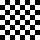

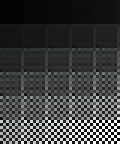


 step: 100, log10(loss): -2.493

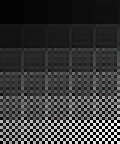


 step: 141, log10(loss): -3.005
 Time (s): 4.906

 Best loss: -3.005

 Num steps: 141


In [16]:
class SamplePool:
    pool_size = ExperimentParams.pool_size
    
    def __init__(self, *, _parent=None, _parent_idx=None, **slots):
        self._parent = _parent
        self._parent_idx = _parent_idx
        self._slot_names = slots.keys()
        self._size = None
        for k, v in slots.items():
            if self._size is None:
                self._size = len(v)
            assert self._size == len(v)
            setattr(self, k, np.asarray(v))
            
    def sample(self, n):
        idx = np.random.choice(self._size, n, False)
        batch = {k: getattr(self, k)[idx] for k in self._slot_names}
        batch = SamplePool(**batch, _parent=self, _parent_idx = idx)
        return batch
    
    def commit(self):
        for k in self._slot_names:
            getattr(self._parent, k)[self._parent_idx] = getattr(self, k)
            
class TrainingConfig:
    def __init__(self):
        self.target = load_image(ExperimentParams.image_data)
        h, w = self.target.shape[:2]
        self.seed = np.zeros([h, w, CellularAutomata.channel_n], np.float32)
        
        # Placing a seed in the center:
        #self.seed[h // 2, w // 2, 3:] = 1.0
        self.ca = CellularAutomata()
        
        # TODO: Verify the random number generator used in the TF optimizer
        self.loss_hist = []
        self.learning_rate = ExperimentParams.learning_rate
        self.lr_sched = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
            boundaries = [2000], 
            values = [self.learning_rate, self.learning_rate * 0.1])
        self.trainer = tf.keras.optimizers.Adam(self.lr_sched)
        
        self.target_loss = ExperimentParams.target_loss
        self.initial_loss = self.get_loss(self.seed).numpy()
        self.pool = SamplePool(x = np.repeat(self.seed[None, ...], SamplePool.pool_size, 0))
        
    def get_loss(self, img):
        return tf.reduce_mean(tf.square(to_rgb(img) - self.target), [-2, -3, -1])
    
    @tf.function
    def train_step(self, x):
        iter_n = ExperimentParams.lifetime
        with tf.GradientTape() as g:
            for i in tf.range(iter_n):
                x = self.ca(x)
            loss = tf.reduce_mean(self.get_loss(x))
            
        grads = g.gradient(loss, self.ca.weights)
        grads = [g / (tf.norm(g) + 1.0e-8) for g in grads]
        self.trainer.apply_gradients(zip(grads, self.ca.weights))
        return x, loss
        
    def show_status(self, initial):
        # Run the CA for its lifetime with the current weights.
        xs = []
        x = initial
        for i in range(ExperimentParams.lifetime):
            x = self.ca(x)
            xs.append(x)

        vis = []
        for i in range(len(xs) // 5):
            vis.append(np.hstack(
                [np.hstack(to_rgb(x).numpy()) for x in xs[5*i : 5*i + 5]]))
        result_image = np.vstack(vis)
        
        imshow(zoom(result_image, 3))
        print("\n step: %d, log10(loss): %.3f" % (
            len(self.loss_hist), np.log10(self.loss_hist[-1])), end='')
    
    def run(self, num_steps, batch_size = 1):
        initial = result = loss = None
        assert num_steps > 0
        for i in range(num_steps):
            initial = np.repeat(self.seed[None, ...], batch_size, 0)
            x, loss = self.train_step(initial)
            self.loss_hist.append(loss.numpy())
            if np.log10(loss) <= self.target_loss:
                break
        self.show_status(initial)

print(vars(ExperimentParams))
training = TrainingConfig()
imshow(zoom(training.target, 5))

def run():
    while not training.loss_hist or min(np.log10(training.loss_hist)) > ExperimentParams.target_loss:
        training.run(num_steps = 100)
import timeit
print("\n Time (s): %.3f" % timeit.timeit(run, number=1))
print("\n Best loss: %.3f" % min(np.log10(training.loss_hist)))
print("\n Num steps: %d" % len(training.loss_hist))

In [ ]:
# Phase 3: testing for target loss rather than number of steps

# Tests on checkerboard 8x8:
# (channel_count, filter_size) => (# steps, time)
data1 = {
    (4, 32): (1130, 22.3),
    (128, 32): (112, 5.868),
    (256, 32): (88, 7.464),
    
    (4, 4): None, # timed-out at 15,000 steps
    (4, 8): None, # timed-out at 10,000 steps
    (4, 16): (3085, 56.941),
    
    (6, 6): (6458, 120.829),
    (8, 8): (2025, 38.033),
    (8, 16): (584, 12.230),
    
    (8, 32): (489, 10.062),
    (8, 64): (233, 6.113),
    (8, 128): (100, 4.295),
    
    (32, 32): (237, 7.401),
    (64, 64): (83, 3.878),
    (128, 128): (95, 7.739),
}

# Tests on square 8x8:
# (channel_count, filter_size) => (# steps, time)
data1 = {
    (4, 4): None, # couldn't learn at all,
    (64, 64): None, # couldn't learn at all
}

# Tests on guided square 8x8:
# (channel_count, filter_size) => (# steps, time)
data1 = {
    (4, 4): None, #timed-out at 8,300 steps
    (32, 32): (74, 3.052),
}

In [ ]:
# Phase 2: testing on various images and trying to improve time to train

# Hypothesis: increasing fire rate will improve loss and not affect time
data3 = {
    0.1: (-0.417, 90),
    1.0: (-2.415, 87),
}
# Removing the update mask calculations entirely reduced time to 84 seconds

# Hypothesis: increasing learning rate will first improve loss and then worsen it and not affect time
# pool_size => (min_loss, time)
data2 = {
    0.1e-3: (-0.344, 51),
    2.0e-3: (-1.737, 51),
    3.0e-3: (-1.742, 52),
    5.0e-3: (-1.751, 52),
    10.0e-3: (-1.751, 52),
    20.0e-3: (-1.639, 53),
}

# Hypothesis: increasing pool size will improve loss but increase time
# pool_size => (min_loss, time)
data2 = {
    8: (-1.737, 52),
    32: (-1.724, 53),
    128: (-1.733, 52),
    1024: (-1.736, 51),
}

# Hypothesis: increasing lifetime will improve loss but increase time
# lifetime => (min_loss, time)
data1 = {
    10: (-0.457, 26),
    30: (-1.731, 51),
    50: (-1.757, 86),
    100: (-1.761, 204),
    200: (-1.765, 362),
}

# 1 -> 2 : 10 times
# 1 -> 1.1 : 

In [ ]:
# Phase 1: testing on Lenna 32x32 and examining channel counts

# Hypothesis: increasing channel count will reduce best loss

# Filter size => (Best loss, Time)
filter_sizes = {
    '4': (-1.674, 134),
    '64': (-1.754, 225),
}

# Channel count => Best Loss
channel_counts = {
    '4': -1.688,
    '5': -1.735,
    '6': -1.705,
    '8': -1.733,
    '10': -1.727,
    '12': -1.751,
    '14': -1.732,
    '16': -1.719,
    '32': -1.742,
}

# Meeting Notes:

- Seed the random numbers the same way, should behave exactly the same
    - Look into that kind of thing in Tensorflow
- Record the seed when an experiment starts
- The parameters are not separable
    - Separable parameters are independent, when you fix one it doesn't affect the other
    - Try each parameter change with a change in each other parameter